## Create Quality Helicorder

### Imports

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt 
import obspy 

from andbro__save_to import __save_to
from andbro__savefig import __savefig
from pandas import read_csv, DataFrame
from matplotlib.patches import Polygon, Patch


from tqdm import tqdm


In [2]:

def __archive_request(seed_id, tstart, tdelta, raw=None):
    
    ''' get data of ROMY for one component from archive 

    VARIABLES:
        seed_id:    code of seismic stations (e.g. "BW.ROMY..BJU")
        tstart:	    begin of time period
        tdelta:     temporal length of period

    DEPENDENCIES:
        import obspy

    EXAMPLE:
        >>> __get_stream_data_archive('BW.ROMY.10.BJZ', '2020-07-17 02:50', 3600, raw=False)

    '''
    from obspy.clients.fdsn import Client

    def __extend_digits(doy):
        if doy < 10:
            doy = f"00{doy}"
        elif doy >= 10 and doy < 100:
            doy = f"0{doy}"
        return doy 


    net, sta, loc, cha = seed_id.split(".")
    
    ## defining parameters
    year = tstart.year
    doy  = tstart.julday
    tend = tstart + tdelta
    
    doy = __extend_digits(doy)
    
    
    ## define station depending if raw is set or not
#     sta = sta if raw is None else f"D{sta}"

    ## define local data path
    pathroot = "/import/freenas-ffb-01-data/romy_archive/"

    ## __________________________________________________________________________
    
    try:
        route = obspy.clients.fdsn.RoutingClient("eida-routing")
        inv   = client.get_stations(network=net, station=sta, level="response")
#         print("  --> inventory was obtained"); obtained_inventory=True

    except:
        if raw is not True:
            print("  --> inventory could not be obtained..."); obtained_inventory=False
    
    ## -------------------------- ##
    if raw is None or raw is False:
        ## recreate file structure of archive
        path = f"{pathroot}{year}/{net}/{sta}/{cha}.D/"
        name = f"{net}.{sta}.{loc}.{cha}.D.{year}.{doy}"
        ## get stream data
        st = obspy.read(path+name, starttime=tstart, endtime= tend)
        
        if obtained_inventory:
            print("  --> trend and response is being removed...")
            return st.detrend("linear").remove_response(inventory=inv) 
        else:
            return st   

    ## -------------------------- ##
    elif raw is True: 
        if sta == "ROMY":
            ## recreate file structure of archive
            path = f"{pathroot}{year}/{net}/DROMY/FJ{cha[2]}.D/"
            name = f"{net}.D{sta}..F{cha[1:3]}.D.{year}.{doy}"
            ## get stream data
            st = obspy.read(path+name, starttime=tstart, endtime= tend)
            return st
        else:
            print("  --> something went wrong! perhaps with seed_id?")


### Configuration

In [3]:
path = '/home/andbro/Documents/ROMY/QualityCheck/runw/'

save = False

In [4]:
   
## interactively 
if len(sys.argv) == 4:
    date_to_analyse = sys.argv[1]
    channel = sys.argv[2]
    path = sys.argv[3]
else:
    date_to_analyse = input("\n Enter the date (e.g. 2019-05-14):  "); print("\n")
    channel = input("\n Enter the channel:  "); print("\n")



date_to_analyse = obspy.UTCDateTime(date_to_analyse)


## setting input paths and files automatically
ipath = f'{path}Cfiles/{str(date_to_analyse)[:7]}/'
iname = f'{date_to_analyse.date}.C{channel[-1]}'

path2qfiles = f'{path}Qfiles/{str(date_to_analyse)[:7]}/'
name2qfiles = f'{date_to_analyse.date}.Q{channel[-1]}'

opathfigs = f'{path}QHeli/{str(date_to_analyse)[:7]}/'
onamefigs = f'ROMY_{date_to_analyse.date}_Q{channel[-1]}heli'

## seed code
if channel[2] == "Z":
    code = f"BW.ROMY.10.{channel}"
else: 
    code = f"BW.ROMY..{channel}"

## important for helicorder devision
time_intervall = 15 # minutes


 Enter the date (e.g. 2019-05-14):  2019-11-14



 Enter the channel:  BJZ




In [5]:
if not os.path.isfile(ipath+iname):
    print(f"\nNo input file found: {ipath+iname}")
    sys.exit

### Load waveform data

In [6]:
from andbro__querrySeismoData import __querrySeismoData

tstart = obspy.UTCDateTime(date_to_analyse)

tdelta = 1440 # minutes

try:
    tr = __archive_request(code, tstart, tdelta*60, raw=False)

except:
    tr, inv = __querrySeismoData(
                                seed_id=code,
                                starttime=tstart,
                                endtime=tstart+tdelta*60,
                                where="george",
                                path=None,
                                restitute=True,
                                detail=None,
                               )


#bjz.plot(type="dayplot", intervall=15);

  --> inventory could not be obtained...
Inventory created at 2021-04-16T11:41:46.913303Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: ObsPy FDSN Routing 1.2.2,SeisComP (GOF)
	Contains:
		Networks (1):
			BW
		Stations (1):
			BW.ROMY (RingLaser, Bavaria, BW-Net)
		Channels (1):
			BW.ROMY.10.BJZ


In [7]:
# from andbro__querrySeismoData import __querrySeismoData

# seed_id = "BW.ROMY.10.BJZ"

# tbeg = obspy.UTCDateTime("2019-11-14 09:25")
# tend = obspy.UTCDateTime("2019-11-14 11:00")

# tr, inv = __querrySeismoData(  
#                                seed_id=seed_id, 
#                                starttime=tbeg, 
#                                endtime=tend, 
#                                where="local", 
#                                path="/home/andbro/Documents/ROMY/data/", 
#                                restitute=True, 
#                                detail=True,
#                              )

# ## processing for this case
# tr[0].data = tr[0].data*0.59604645e-6
# tr.detrend('simple')

In [8]:
## check if multiple traces in stream
if len(tr) > 1: 
    tr.merge()

## check if trace is masked array (if true -> replace broken values with 0.0)
if np.ma.is_masked(tr[0].data):
    tr[0].data = np.ma.filled(tr[0].data, 0.0)


### Load quality data

In [9]:
def __get_params(path2qfiles, name2qfiles):
    
    ## read header information 
    qfile = open(path2qfiles+name2qfiles, 'r')
    line = qfile.readline()
    qfile.close()

    ## extract parameters
    param = int(line.split(" ")[2]), int(line.split(" ")[4]), float(line.split(" ")[6])
    print(param)
    ## define time delta
    delta_T = param[2]*param[1]
    shift_T = param[0]/2
    
    return delta_T, shift_T

In [10]:
## infer input filename
# iname = f"{tstart.date}.C"

## read the quality data for the component
colors_in = read_csv(ipath+iname, names=['seconds', 'quality'], header=0)

## correct the interval center 
delta_T, shift_T = __get_params(path2qfiles, name2qfiles)
colors_in.seconds = colors_in.seconds - shift_T

## define array with intervall cuts as seconds
edges = np.arange(0,1440*60+60*time_intervall,60*time_intervall)

## creating a data frame with values at the cuts of the intervall for the helicorder
df = DataFrame({"idx":np.zeros(len(edges))*np.NaN, "seconds":edges, "quality":np.zeros(len(edges))*np.NaN})

## joining the dataframes and sort of extrapolating the quality values
colors = colors_in.append(df).sort_values('seconds').reset_index().fillna(method='ffill')
colors = colors[['seconds', 'quality']]
colors.quality.iloc._setitem_with_indexer(0, colors.quality.iloc[1])


colors.head()


(20, 2, 0.5)


,seconds,quality
0,0.0,2.0
1,899.0,2.0
2,900.0,2.0
3,1800.0,2.0
4,2700.0,2.0


In [11]:

def __plotQualityHelicorder(trace, colors, intervall, hours_to_show=12, hours_shift=None):

    
#     intervall = 15 # minutes
#     hours_to_show = 12 # hours
#     hours_shift = 12 # hours    

    factor = 2 # offset of lines

    tstart = trace[0].stats.starttime
    

    ## modify time the helicorder start 
    if hours_shift:
        tstart += hours_shift*3600

    ## ___________________________________________________________
    ##

    fig, ax  = plt.subplots(1,1, figsize=(15,15))

    fs = 14

    for k in range(int(hours_to_show*60/intervall)):
        
        ## define time windows according to set intervall variable
        dt_min = k*intervall*60
        dt_max = (k+1)*intervall*60

        if hours_shift:
            t1 = hours_shift*3600 + dt_min
            t2 = hours_shift*3600 + dt_max
        else:
            t1 = dt_min
            t2 = dt_max
    
        #load data for current window
        dat1 = trace.slice(tstart+dt_min,tstart+dt_max).detrend('simple')
        dat2 = colors[(colors.seconds <= t2) & (colors.seconds >= t1)].reset_index()

        ## automatically generate time axis
        timeline = np.arange(0,intervall*60, intervall*60/len(dat1[0].data))
        
        ## plot trace data
        ax.plot(timeline, dat1[0].data/max(dat1[0].data)-factor*k, 'k')

        ## add color polygons according to quality
        for i in range(len(dat2.seconds)-1): 

            x1, x2, y1, y2 = dat2.iloc[i,1]-t1, dat2.iloc[i+1,1]-t1, -factor*k-1.0, -factor*k+1.0

            if dat2.quality[i] == 0:
                q0 = ax.add_patch(Polygon([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], closed=True, fill=True, color='green',alpha=0.5, lw=0.0))
                
            if dat2.quality[i] == 1:
                q1 = ax.add_patch(Polygon([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], closed=True, fill=True, color='gold',alpha=0.5, lw=0.0))

            if dat2.quality[i] == 2:
                q2 = ax.add_patch(Polygon([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], closed=True, fill=True, color='darkred',alpha=0.5, lw=0.0))


    ## axes configurations
    ax.set_xlabel('Time (min)',fontsize = fs)
    ax.set_xticks(np.arange(0,900+60*1,60*1))
    ax.set_xticklabels([0,'','','','',5,'','','','',10,'','','','',15], fontsize=fs-1)
    
    ax.set_ylabel(f'UTC from {tstart.date}', fontsize=fs)
    ax.set_yticks(np.arange(0,-hours_to_show*8,-factor*4))
    
    ## define y-labels
    hourlabels = []
    for i in range(hours_to_show):
        if hours_shift:
            i += hours_shift
        if i < 10:
            hourlabels.append(f'0{i}:00')
        else:
            hourlabels.append(f'{i}:00')
    
    ax.set_yticklabels(hourlabels, fontsize=fs-1)
   
    ## add a title
    ax.set_title(f'{dat1[0].stats.network}.{dat1[0].stats.station}.{dat1[0].stats.location}.{dat1[0].stats.channel}', fontsize=fs+2)

    ## add legend 
    legend_elements = [
                       Patch(facecolor='green', edgecolor='green', label='Q0', alpha=0.7),
                       Patch(facecolor='gold', edgecolor='gold', label='Q1', alpha=0.8),
                       Patch(facecolor='darkred', edgecolor='darkred', label='Q2', alpha=0.7)
                      ]

    ax.legend(handles=legend_elements, loc='upper center', fontsize=fs, ncol=4, edgecolor='black')



#     plt.show();
    return fig


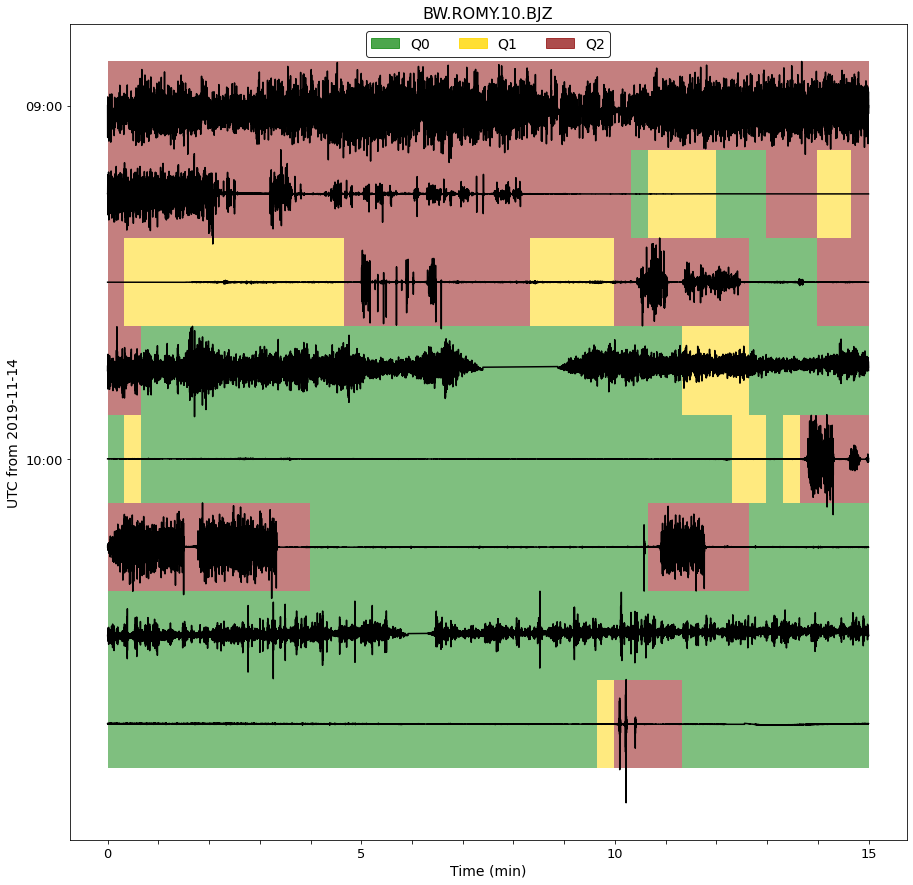

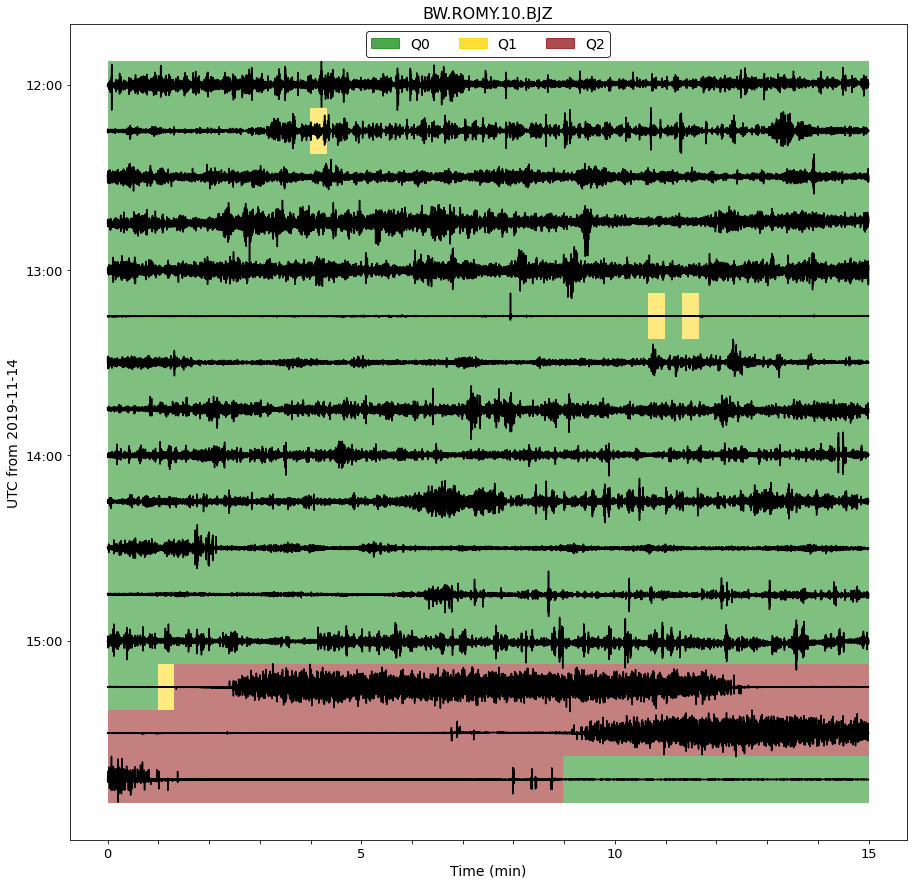

In [12]:
if not os.path.isdir(opathfigs):
    os.mkdir(opathfigs)

## _____________________________________________
##
    
## auto define output filename
oname = f'ROMY_{tstart.date}_QHeli(1)'

## generate plot
fig = __plotQualityHelicorder(tr, colors, intervall=time_intervall, hours_to_show=2, hours_shift=9)

## save plot as pdf 
if save:
    __savefig(fig, outpath=opathfigs, outname=oname, mode="pdf");

## _____________________________________________
##

## auto define output filename
oname = f'ROMY_{tstart.date}_QHeli(2)'

## generate plot
fig = __plotQualityHelicorder(tr, colors, intervall=time_intervall, hours_to_show=4, hours_shift=12)

## save plot as pdf 
if save:
    __savefig(fig, outpath=opathfigs, outname=oname, mode="pdf");
